# **IEEE-CIS Fraud Detection**

**Install libraries** 

In [1]:
!pip install pyfiglet
!pip install opendatasets

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#import sys
#sys.path.append('/content/drive/MyDrive/function')

# **Importation des librairies**

In [4]:
import numpy             as np # linear algebra
import pandas            as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn           as sns
import matplotlib.pyplot as plt
import opendatasets      as od
import functions
import warnings
import pyfiglet
import gc


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from imblearn.over_sampling    import SMOTE
from sklearn.preprocessing     import StandardScaler
from sklearn.svm               import SVC
from sklearn.linear_model      import LogisticRegression
from sklearn.ensemble          import RandomForestClassifier
from sklearn.model_selection   import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, KFold, cross_validate
from sklearn.metrics           import accuracy_score
from sklearn.preprocessing     import RobustScaler
from sklearn.preprocessing     import LabelEncoder
from sklearn.ensemble          import VotingClassifier
from sklearn.ensemble          import StackingClassifier
from sklearn                   import preprocessing
from imblearn.metrics          import geometric_mean_score
from imblearn.metrics          import classification_report_imbalanced



In [5]:
ascii_banner = pyfiglet.figlet_format("PyFraudPredict models")
print(ascii_banner)

 ____        _____                    _ ____               _ _      _   
|  _ \ _   _|  ___| __ __ _ _   _  __| |  _ \ _ __ ___  __| (_) ___| |_ 
| |_) | | | | |_ | '__/ _` | | | |/ _` | |_) | '__/ _ \/ _` | |/ __| __|
|  __/| |_| |  _|| | | (_| | |_| | (_| |  __/| | |  __/ (_| | | (__| |_ 
|_|    \__, |_|  |_|  \__,_|\__,_|\__,_|_|   |_|  \___|\__,_|_|\___|\__|
       |___/                                                            
                     _      _     
 _ __ ___   ___   __| | ___| |___ 
| '_ ` _ \ / _ \ / _` |/ _ \ / __|
| | | | | | (_) | (_| |  __/ \__ \
|_| |_| |_|\___/ \__,_|\___|_|___/
                                  



**Suppression des Warnings**

In [6]:
warnings.simplefilter("ignore")

# **Récupération du dataset**

In [7]:
url="https://www.kaggle.com/c/ieee-fraud-detection/data"
od.download(url)

Skipping, found downloaded files in ".\ieee-fraud-detection" (use force=True to force download)


**Chargement des différents dataset**

In [8]:
%%time
sample              = pd.read_csv("ieee-fraud-detection/sample_submission.csv")
df_identity         = pd.read_csv("ieee-fraud-detection/train_identity.csv")
df_transaction      = pd.read_csv("ieee-fraud-detection/train_transaction.csv")
df_test_transaction = pd.read_csv("ieee-fraud-detection/test_transaction.csv")
df_test_identity    = pd.read_csv("ieee-fraud-detection/test_identity.csv")

Wall time: 2min 8s


**Merge train and test data**

In [9]:
train = df_transaction.merge(df_identity, how="left", on="TransactionID")
test  = df_test_transaction.merge(df_test_identity, how="left", on="TransactionID")

**Reduction de la mémoire**

In [10]:
%%time
sample    = functions.reduce_mem_usage(sample)
train     = functions.reduce_mem_usage(train)
test      = functions.reduce_mem_usage(test)

Mem. usage decreased to  2.90 Mb (62.5% reduction)
Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)
Wall time: 4min 24s
Parser   : 183 ms


In [11]:
gc.collect()

0

# **1- Analyse exploratoire**





**Sample dataset**

In [12]:
sample.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  506691 non-null  int32  
 1   isFraud        506691 non-null  float16
dtypes: float16(1), int32(1)
memory usage: 2.9 MB


In [13]:
sample.head(3)

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5


In [14]:
sample['isFraud'].unique()

array([0.5], dtype=float16)

**Remarque:**  La variable cible "isFraud" du dataset "sample_submission" se compose uniquement de la valeur 0.5. Ceci rend ce dataset inutilisable en dehors de la compétation kaggle.

**Train dataset**

In [15]:
print("Train dataset identity")
train.head(5)

Train dataset identity


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 650.5+ MB


In [17]:
train.describe(include="all")

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540,590540.000000,581607.0,588975.0,588963,586281.0,...,140282,77586.0,73289,77805,140985,140985,140985,140985,140810,118666
unique,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,4,NaN,...,130,NaN,260,4,2,2,2,2,2,1786
top,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,visa,NaN,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,NaN,NaN,NaN,NaN,439670,NaN,NaN,NaN,384767,NaN,...,22000,NaN,16874,60011,77814,134066,110452,73922,85165,47722
mean,3.282270e+06,0.034990,7.372311e+06,NaN,NaN,9898.734658,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.704744e+05,0.183755,4.617224e+06,NaN,NaN,4901.170153,NaN,0.0,NaN,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.987000e+06,0.000000,8.640000e+04,0.250977,NaN,1000.000000,100.0,100.0,NaN,100.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,NaN,6019.000000,214.0,150.0,NaN,166.0,...,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,NaN,9678.000000,361.0,150.0,NaN,226.0,...,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,NaN,14184.000000,512.0,150.0,NaN,226.0,...,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
train.shape

(590540, 434)

In [19]:
print("Nombre d'observation ayant des valeurs manquantes: ", train.isnull().any(axis = 1).sum())

Nombre d'observation ayant des valeurs manquantes:  590540


**Remarque:** Chaque observation contient au moins une valeur manquante

In [20]:
print("Nombre de features ayant des valeurs manquantes: ", train.isnull().any(axis = 0).sum())

Nombre de features ayant des valeurs manquantes:  414


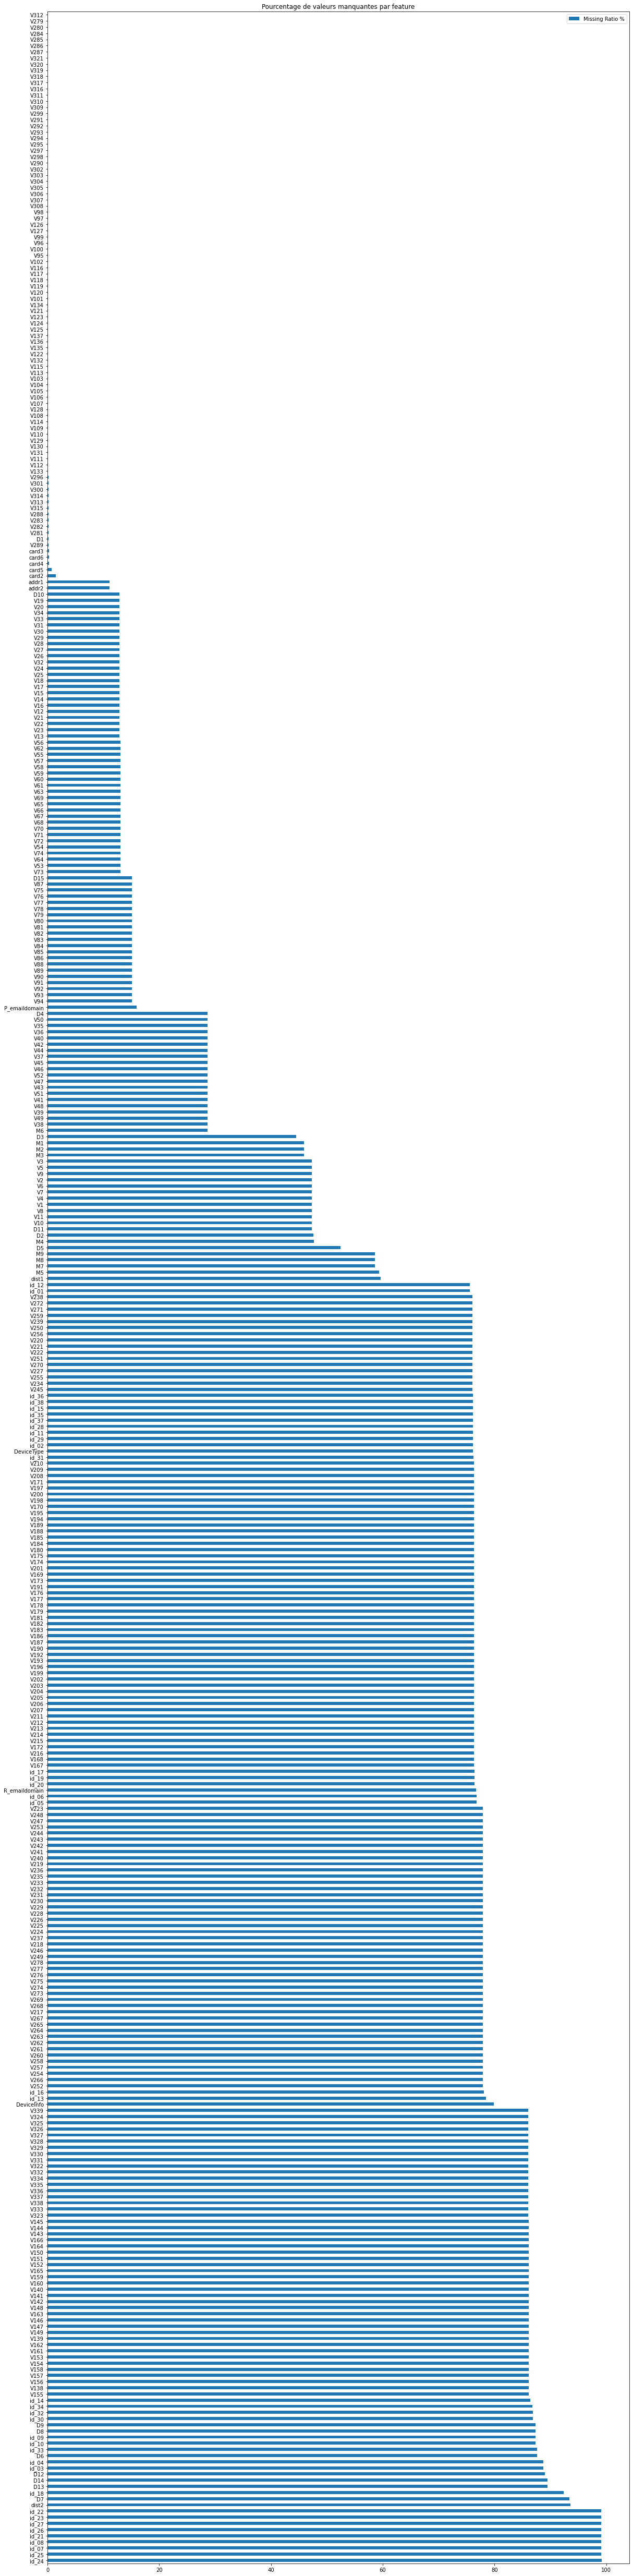

In [21]:
plot_width, plot_height = (20,90)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
functions.plot_nas(train)

**Elimination des features ayant plus de 75% de valeurs manquantes**

In [22]:
treshold = 75.0
min_count =  int(((100-treshold)/100)*train.shape[0] + 1)
train = train.dropna( axis=1, 
                thresh=min_count)

In [23]:
print("Nombre de valeurs manquantes dans la train dataset: ", train.isnull().sum().sum())

Nombre de valeurs manquantes dans la train dataset:  16088043


**Imputation des valeurs manquantes**

In [24]:
%%time
train = functions.fill_miss_val(train)

Nombre de valeur manquantes après l'imputation:  0
Wall time: 2min 50s


In [25]:
gc.collect()

58363

In [26]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,0.0,150.0,discover,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Boxplot d'un sous ensemble de features du train dataset**

In [27]:
train.shape

(590540, 226)

<AxesSubplot:>

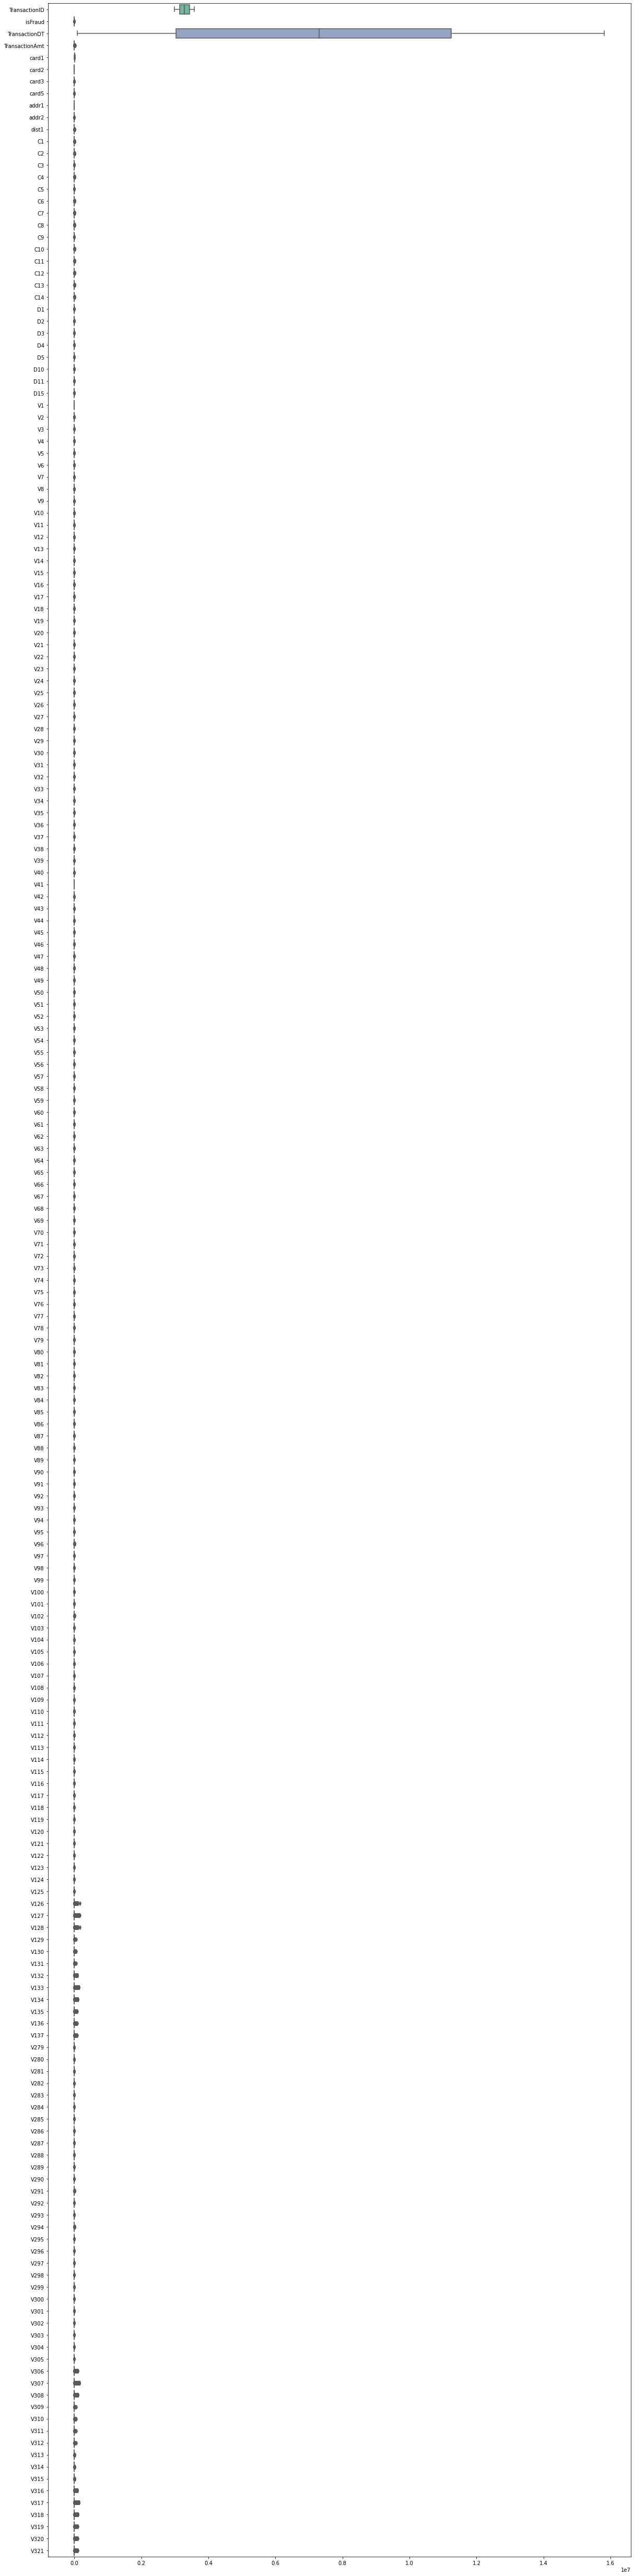

In [28]:
sns.boxplot(data=train, orient="h", palette="Set2")

**Remarque:** Ce graphe nous montre qu'il y'a pas d'outlier dans le train

**Histogram**

Wall time: 12.5 s


array([[<AxesSubplot:title={'center':'TransactionID'}>,
        <AxesSubplot:title={'center':'isFraud'}>,
        <AxesSubplot:title={'center':'TransactionDT'}>,
        <AxesSubplot:title={'center':'TransactionAmt'}>,
        <AxesSubplot:title={'center':'card1'}>,
        <AxesSubplot:title={'center':'card2'}>,
        <AxesSubplot:title={'center':'card3'}>,
        <AxesSubplot:title={'center':'card5'}>,
        <AxesSubplot:title={'center':'addr1'}>,
        <AxesSubplot:title={'center':'addr2'}>,
        <AxesSubplot:title={'center':'dist1'}>,
        <AxesSubplot:title={'center':'C1'}>,
        <AxesSubplot:title={'center':'C2'}>,
        <AxesSubplot:title={'center':'C3'}>,
        <AxesSubplot:title={'center':'C4'}>],
       [<AxesSubplot:title={'center':'C5'}>,
        <AxesSubplot:title={'center':'C6'}>,
        <AxesSubplot:title={'center':'C7'}>,
        <AxesSubplot:title={'center':'C8'}>,
        <AxesSubplot:title={'center':'C9'}>,
        <AxesSubplot:title={'center':'C

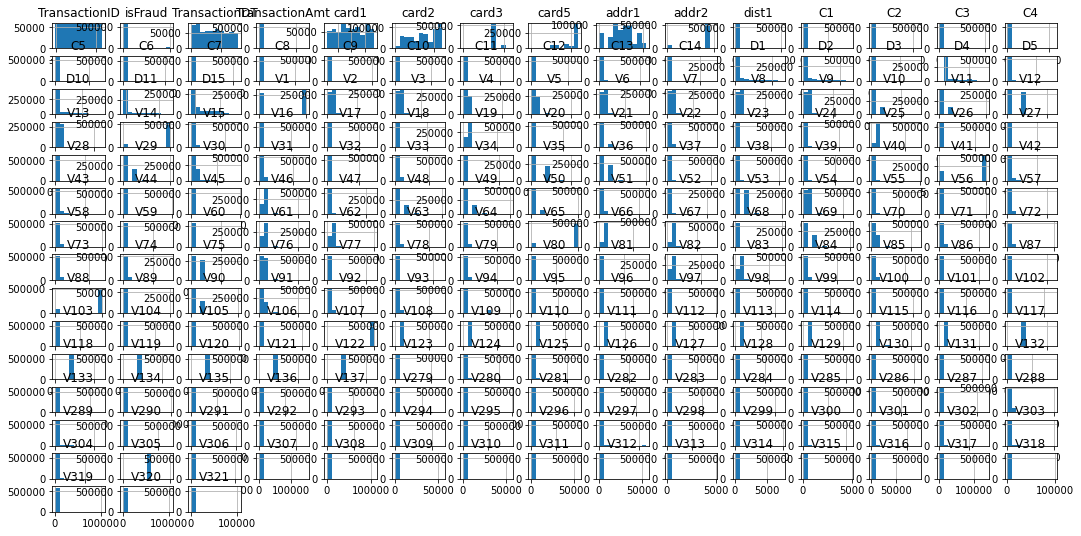

In [29]:
%%time
train.hist(figsize=(18,9))

**Analyse de la variable cible**

In [30]:
train['isFraud'].value_counts(normalize=True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

**Remarque:** Nous constatons ici que le train dataset contient pratiquement 96% d'observations non frauduleuse. Nous sommes donc face à un dataset contenant des classes déséquilibrés. Un modèle basé sur ce dataset est susceptible de produire un modèle biaisé. Par la suite, il faudra donc reéchantillonné le dataset pour pouvoir obtenir un modèle avec des prédictions non biaisés.  

**Encodage des valeurs categorielle**

In [31]:
gc.collect()

120

In [32]:
train = functions.encode_df(train)

**Analyse de la correlation**

In [33]:
# correlation matrix
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Suppression des features 
train.drop(to_drop, axis=1, inplace=True)

In [34]:
gc.collect()

0

In [35]:
train.shape

(590540, 241)

**Test dataset**

In [36]:
test.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
if ('isFraud' not in test.columns) and ('isFraud' not in test.columns):
    print(" Le dataframe de test ne contient pas de la variable cible 'isFraud'. Ceci rend ce dataframe inutilisable dans le cadre de notre projet.\n\n Pour la suite, nous allons donc utiliser principalement les dataframe Train")

 Le dataframe de test ne contient pas de la variable cible 'isFraud'. Ceci rend ce dataframe inutilisable dans le cadre de notre projet.

 Pour la suite, nous allons donc utiliser principalement les dataframe Train


**Train test split**

In [38]:
feats  = train.drop('isFraud', axis=1)
target = train.isFraud
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.25)

In [39]:
gc.collect()

0

**Features selection**

In [40]:
X_train_fs, X_test_fs = functions.select_features(X_train, y_train, X_test)

In [41]:
gc.collect()

0

**Features scaling**

In [42]:
#feature scaling with robustScaler
transformer = RobustScaler().fit(X_train_fs)
X_train = transformer.transform(X_train_fs)
X_test  = transformer.transform(X_test_fs)

In [43]:
gc.collect()

0

**Dataset resampling with SMOTE**

In [44]:
#Dataset resampling with SMOTE: 
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

Classes échantillon SMOTE : {0: 427393, 1: 427393}


In [45]:
gc.collect()

0

# **2- Entrainement et optimisation des hyperparamètres**

# A- Aprrentissage supervisé

**1- Lightgbm model**


In [46]:
# build the lightgbm model
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_sm, y_sm)

LGBMClassifier()

In [47]:
# predict the results
y_pred=clf.predict(X_test)

In [48]:
from sklearn.metrics import accuracy_score
accuracy_LightGBM=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_LightGBM))

LightGBM Model accuracy score: 0.9491


 **Comparaison de l'accuracy du train and test**

Cette comparaison nous permettra de vérifier que nous n'avons pas d'overfitting (suraprrentissage).

In [49]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9507
Test set score: 0.9491


**Note:** Le score (accuracy) obtenu en utilisant le train est presque similaire à celui obtenu avec le test dataset. Nous pouvons conclure que nous ne sommes pas en présence d'un cas d'overfitting 

**Lightgbm Hyperparameter optimization**

In [50]:
clf_lgb = lgb.LGBMClassifier()
params_lgb = {
    'num_leaves':[20,40,60,80,100], 
    'min_data_in_leaf':[200,300,400],
    'max_depth':[4,6,8],
    'learning_rate':[0.05,0.1,0.2],
}

gridcv_lgb = GridSearchCV(clf_lgb, param_grid=params_lgb, scoring='accuracy', cv=3)   

In [51]:
gridcv_lgb.fit(X_sm, y_sm)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300


GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [4, 6, 8],
                         'min_data_in_leaf': [200, 300, 400],
                         'num_leaves': [20, 40, 60, 80, 100]},
             scoring='accuracy')

In [52]:
pd.DataFrame(gridcv_lgb.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,"{'learning_rate': 0.05, 'max_depth': 4, 'min_d...",0.886265,0.008841
1,"{'learning_rate': 0.05, 'max_depth': 4, 'min_d...",0.886265,0.008841
2,"{'learning_rate': 0.05, 'max_depth': 4, 'min_d...",0.886265,0.008841
3,"{'learning_rate': 0.05, 'max_depth': 4, 'min_d...",0.886265,0.008841
4,"{'learning_rate': 0.05, 'max_depth': 4, 'min_d...",0.886265,0.008841
...,...,...,...
130,"{'learning_rate': 0.2, 'max_depth': 8, 'min_da...",0.948947,0.012594
131,"{'learning_rate': 0.2, 'max_depth': 8, 'min_da...",0.957143,0.011977
132,"{'learning_rate': 0.2, 'max_depth': 8, 'min_da...",0.960182,0.013227
133,"{'learning_rate': 0.2, 'max_depth': 8, 'min_da...",0.960789,0.012587


In [53]:
gridcv_lgb.best_params_

{'learning_rate': 0.2,
 'max_depth': 8,
 'min_data_in_leaf': 300,
 'num_leaves': 100}

In [54]:
pred_lgb=gridcv_lgb.predict(X_test)

In [55]:
print('Test set score: {:.4f}'.format(accuracy_score(y_test, pred_lgb)))

Test set score: 0.9606


In [56]:
from sklearn.metrics import classification_report
print("Classication report for lightgbm: \n")
print(classification_report(y_test, pred_lgb))

Classication report for lightgbm: 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    142484
           1       0.44      0.50      0.47      5151

    accuracy                           0.96    147635
   macro avg       0.71      0.74      0.72    147635
weighted avg       0.96      0.96      0.96    147635



In [57]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, pred_lgb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.98      0.50      0.98      0.70      0.51    142484
          1       0.44      0.50      0.98      0.47      0.70      0.46      5151

avg / total       0.96      0.96      0.51      0.96      0.70      0.51    147635



In [ ]:

lgb_gmean = geometric_mean_score(y_test, pred_lgb, average='micro')

**Confusion Matrix**

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [59]:
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[137640   4844]
 [  2674   2477]]

True Positives(TP) =  137640

True Negatives(TN) =  2477

False Positives(FP) =  4844

False Negatives(FN) =  2674


**2- LogisticRegression, RandomForest and SVC**

In [60]:
clf_lr = LogisticRegression(random_state=22, max_iter=1000)
clf_rf = RandomForestClassifier(random_state=22)
clf_svc = SVC(random_state=22)


param_grid_lr = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-1, 1, 4)}

param_grid_rf = [{'n_estimators': [10, 50, 100], 
                  'min_samples_leaf': [1, 3, 5], 
                  'max_features': ['sqrt', 'log2']}]

param_grid_svc = [{'kernel': ['rbf'], 'C': [1,10,100], 'gamma': [1, 0.1, 0.01, 0.001]},
                  {'kernel': ['linear'], 'C': [1,10,100]}]

In [61]:
gridcvs ={}

for pgrid, clf, name in zip((param_grid_lr, param_grid_rf, param_grid_svc),
                            (clf_lr, clf_rf, clf_svc),
                            ('LogisticRegression', 'RF', 'SVM')):
    gcv = GridSearchCV(clf, pgrid, cv=3, refit=True)
    gridcvs[name] = gcv

In [ ]:
outer_cv = StratifiedKFold(n_splits=3, shuffle=True)
outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, X_sm, y_sm, cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

In [ ]:
svc_accuracy = gridcvs['SVM'].fit(X_sm, y_sm).score(X_test, y_test)
final_svc = gridcvs['SVM']
final_svc.fit(X_sm, y_sm)

print("Classication report for SVC: \n")
print(classification_report(y_test, final_svc.predict(X_test)))

In [ ]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, final_svc.predict(X_test)))

In [ ]:
lr_accuracy = gridcvs['LogisticRegression'].fit(X_sm, y_sm).score(X_test, y_test)
final_lr = gridcvs['LogisticRegression']
final_lr.fit(X_sm, y_sm)

print("Classication report for Logistic Regression: \n")
print(classification_report(y_test, final_lr.predict(X_test)))

In [ ]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, final_lr.predict(X_test)))

In [ ]:
final_clf = gridcvs['RF']
final_clf.fit(X_sm, y_sm)

print(f'Best Parameters: {final_clf.best_params_}')

train_rf_acc = accuracy_score(y_true=y_sm, y_pred=final_clf.predict(X_sm))
test_rf_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_rf_acc:.2f}')
print(f'Test Accuracy: {100*test_rf_acc:.2f}')

In [ ]:
print("Classication report for random forest: \n")
print(classification_report(y_test, final_clf.predict(X_test)))

In [ ]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, final_clf.predict(X_test)))

**Note:** Nous allons sélectionner et entraîner le meilleur algorithme, celui avec le plus haut taux de précision moyenne et le plus faible écart-type

**3- StackingClassifier**

In [ ]:
cv3 = KFold(n_splits=3, random_state=111, shuffle = True)

sclf = StackingClassifier(estimators=[('LR', clf_lr), ('rf', clf_rf), ('svc', clf_svc)], 
                          final_estimator= clf_svc)

scores = cross_validate(sclf, X_sm, y_sm, 
                                              cv=cv3, scoring=['accuracy','f1'])
print("[StackingClassifier]: \n Accuracy: %0.2f (+/- %0.2f)\n" 
      % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
      "F1 score: %0.2f (+/- %0.2f)"
      % (scores['test_f1'].mean(), scores['test_f1'].std()))


In [ ]:
sclf_accuracy = sclf.fit(X_sm, y_sm).score(X_test, y_test)

In [ ]:
sclf_accuracy

In [ ]:
print("Classication report for StackingClassifier : \n")
print(classification_report(y_test, sclf.predict(X_test)))

In [ ]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, sclf.predict(X_test)))

**Comparaison des accuracy**

In [ ]:
data = {'Accuracy': [accuracy_LightGBM,lr_accuracy,test_rf_acc,svc_accuracy,sclf_accuracy]}
df_acc = pd.DataFrame(data,columns=['Accuracy'], index = ['LightGBM','Logistic Regression','RandomForestClassifier','SVC','StackingClassifier'])

df_acc.plot.barh()

plt.title('Accuracy comparison')
plt.ylabel('Model')
plt.xlabel('Accuracy')
plt.show()

**Note:** Nous constatons que les scores sont presque tous identiques

# B- Aprrentissage non supervisé

**1- Isolation forest**

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
clf_isolation=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.01),max_features=1.0)
clf_isolation.fit(X_sm)

In [ ]:
plt.scatter(X_sm[:,0],X_sm[:,1], c=clf_isolation.predict(X_sm))

In [ ]:
data = {'Score':clf_isolation.decision_function(X_sm), 'Anomaly':clf_isolation.predict(X_sm)}  
dfIso = pd.DataFrame(data)  
dfIso.head(20)

In [ ]:
test_data =np.array(y_test)
dfPred = pd.DataFrame({ 'Pred': clf_isolation.predict(X_test)}, columns=['Pred'])
#1: fraudulent transaction. 0: normal transaction
dfPred["Pred"].replace({"-1": "1", "1": "0"}, inplace=True)
dfPred.head()

In [ ]:
dfPred['Real'] = test_data

In [ ]:
dfPred.head()

In [ ]:
test_data.shape

In [ ]:
y_test

In [ ]:
dfPred['Real'] = dfPred['Real'].replace([1,-1],[0,1])


In [ ]:
dfPred.value_counts()

In [ ]:
print("Classication report for isolation forest: \n")
print(classification_report(y_test, clf_isolation.predict(X_test)))

In [ ]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, clf_isolation.predict(X_test)))

 **2- Elliptic envelope**


In [ ]:
from sklearn.covariance import EllipticEnvelope

In [ ]:
clf_elliptic=EllipticEnvelope(contamination=0.03)
clf_elliptic.fit(X_sm)

In [ ]:
plt.scatter(X_sm[:,0],X_sm[:,1], c=clf_elliptic.predict(X_sm))
plt.show()

In [ ]:
data_ = {'Score':clf_elliptic.decision_function(X_sm), 'Anomaly':clf_elliptic.predict(X_sm)}  
dfEl = pd.DataFrame(data)  
dfEl.head()

In [ ]:
dfPred_el = pd.DataFrame({ 'Pred': clf_elliptic.predict(X_test)}, columns=['Pred'])


dfPred_el['Real'] = test_data

dfPred_el.head()

In [ ]:
print("Classication report for isolation forest: \n")
print(classification_report(y_test, clf_elliptic.predict(X_test)))

In [ ]:
#classification_report_imbalanced
#Output: precision, recall, specificity, geometric mean, and index balanced accuracy
print(classification_report_imbalanced(y_test, clf_elliptic.predict(X_test)))

# **C- Compraison des performances**

In [ ]:
# initialize list of lists
data = [['XX', 'XX', 'XX', 'XX'], ['XX', 'XX', 'XX', 'XX'], ['XX', 'XX', 'XX', 'XX'], ['XX', 'XX', 'XX', 'XX']]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Lightgbm', 'StackingClassifier', 'Isolation forest', 'Elliptic envelope'], index=['Gmean', 'F-score', 'Precision', 'Recall']))

# **3- Sauvegarde du model**

In [ ]:
from joblib import dump, load
import joblib

In [ ]:
# save the model to disk

In [ ]:
filename = 'finalized_model.sav'
joblib.dump(sclf, filename)


In [ ]:
 # load the model from disk

In [ ]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

In [ ]:

Notebook(Block de text)
Metrics (F1 score et Gmean)